# Set up the environment

Before running the notebook, please ensure the necessary packages are installed in the kernel environment where this notebook is running.
**Required packages:** See `requirements.txt`. Run `pip install -r requirements.txt` before executing this notebook. Alternatively,
uncomment and run the cell below to install packages manually. 

In [ ]:
""" %pip install glob
%pip install numpy
%pip install laspy
%pip install open3d-python
%pip install polars
%pip install pandas
%pip install rasterio
%pip install matplotlib
%pip install scipy """

In [ ]:
import os
import glob
import numpy as np
import laspy
import open3d as o3d
import polars as pl
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from scipy.stats import entropy


#### Data Imports

In [ ]:
las_file = "C:/Users/harre/RS_Technical/ALS_pointcloud.las" #Replace with local filepath
downsampled_las = "C:/Users/harre/RS_Analyst_Technical_Assignments/structural_metrics/data/downsampled.las" #Replace with local filepath
output_dir = "C:/Users/harre/RS_Analyst_Technical_Assignments/structural_metrics/data"
voxel_size = 0.25
grid_resolution = 0.5
crs_epsg = "EPSG:32637"

#### Downsample .las file

In [ ]:
def voxel_downsample_las(las_file: str, output_dir: str, voxel_size: float = voxel_size):
    """
    Downsamples a .las file using voxel grid filtering and saves the result.
    
    Parameters:
        las_file (str): Path to the input .las or .laz file.
        output_dir (str): Directory to save the downsampled .las file.
        voxel_size (float): Voxel size in meters.
        
    Output:
        Saves a downsampled LAS file as 'downsampled.las' in output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)

    print(f"Reading: {las_file}")
    las = laspy.read(las_file)
    points = np.vstack((las.x, las.y, las.z)).T
    print(f"Original point count: {points.shape[0]}")

    print(f"Downsampling with voxel size: {voxel_size} m")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
    down_points = np.asarray(pcd_down.points)
    print(f"Downsampled point count: {down_points.shape[0]}")

    # Create new LAS object and copy header info
    down_las = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
    
    # Set coordinates
    down_las.x = down_points[:, 0]
    down_las.y = down_points[:, 1]
    down_las.z = down_points[:, 2]

    # Save file
    out_path = os.path.join(output_dir, "downsampled.las")
    down_las.write(out_path)
    print(f"Downsampled LAS file saved to: {out_path}")

In [ ]:
las_downsampled = voxel_downsample_las(las_file, output_dir)

In [ ]:
# Read LAS file metadata
def fetch_las_metadata(las_file: str):
    las = laspy.read(las_file)
    """ Print basic metadata """
    print(f"File: {las_file}")
    print(f"Point format: {las.header.point_format}")
    print(f"Point count: {las.header.point_count}")
    print(f"Bounds (XYZ):")
    print(f"  X: {las.header.min[0]} to {las.header.max[0]}")
    print(f"  Y: {las.header.min[1]} to {las.header.max[1]}")
    print(f"  Z: {las.header.min[2]} to {las.header.max[2]}")

    # Print available attributes (e.g., return number, intensity)
    print("\nAvailable dimensions:")
    print(list(las.point_format.dimension_names))


    try:
        crs = las.header.parse_crs()
        if crs:
            print("\nCoordinate Reference System (CRS):")
            print(crs)
        else:
            print("\nCRS not embedded in the LAS file.")
    except AttributeError:
        print("\nCRS extraction not supported for this LAS version or library version.")

fetch_las_metadata(downsampled_las)

#### Extract ground-classified points and generate DTM

In [ ]:
# Load Original LAS and Extract Ground Points
las = laspy.read(las_file)
x, y, z = las.x, las.y, las.z
classification = las.classification

# Select only ground points (ASPRS code 2)
ground_mask = classification == 2
x_ground = x[ground_mask]
y_ground = y[ground_mask]
z_ground = z[ground_mask]

# Generate DTM Grid
grid_res = 0.5  # meters
xmin, xmax = x_ground.min(), x_ground.max()
ymin, ymax = y_ground.min(), y_ground.max()
ncols = int((xmax - xmin) / grid_res) + 1
nrows = int((ymax - ymin) / grid_res) + 1

# Convert to grid indices
col = ((x_ground - xmin) / grid_res).astype(int)
row = ((ymax - y_ground) / grid_res).astype(int)

# Create DTM array
dtm = np.full((nrows, ncols), np.nan)
flat_dtm = dtm.ravel()
flat_idx = row * ncols + col

# Create temporary array for updating min values
existing = flat_dtm[flat_idx]
new = z_ground

# Replace nan with inf for comparison
existing_nan_mask = np.isnan(existing)
existing[existing_nan_mask] = np.inf
updated = np.minimum(existing, new)
flat_dtm[flat_idx] = updated

dtm = flat_dtm.reshape((nrows, ncols))

#### Normalize the downsampled point cloud with DTM heights

In [ ]:
las_ds = laspy.read(downsampled_las)
x_ds, y_ds, z_ds = las_ds.x, las_ds.y, las_ds.z

# Convert (x, y) to raster indices
col_ds = ((x_ds - xmin) / grid_res).astype(int)
row_ds = ((ymax - y_ds) / grid_res).astype(int)

# Initialize height array
height = np.full_like(z_ds, np.nan)

# Mask valid points within DTM extent
valid = (row_ds >= 0) & (row_ds < dtm.shape[0]) & (col_ds >= 0) & (col_ds < dtm.shape[1])
ground_z = np.full_like(z_ds, np.nan)
ground_z[valid] = dtm[row_ds[valid], col_ds[valid]]

# Compute height above ground
height[valid] = z_ds[valid] - ground_z[valid]

# Create DataFrame with Normalized Heights
normalized_df = pl.DataFrame({
    "x": np.asarray(x_ds),
    "y": np.asarray(y_ds),
    "z": np.asarray(z_ds),
    "ground_z": np.asarray(ground_z),
    "height": np.asarray(height),
    "row": np.asarray(row_ds),
    "col": np.asarray(col_ds)
}).with_columns([
    (pl.col("height") > 2.0).alias("above2"),
    (pl.col("height").is_between(2.0, 10.0)).alias("z_mid")
])

# Filter invalid heights (NaN, negative, or above 70 m)
normalized_df = normalized_df.filter(
    (pl.col("height").is_not_null()) &
    (pl.col("height") >= 0) &
    (pl.col("height") <= 70)
)

print(normalized_df.select(["height"]).describe())
print("\nProportion above 2m:", normalized_df.select(pl.col("above2").mean()).item())
print("Proportion in 2-10m:", normalized_df.select(pl.col("z_mid").mean()).item())


shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ height     │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.438965e7 │
│ null_count ┆ 0.0        │
│ mean       ┆ 2.011185   │
│ std        ┆ 1.797174   │
│ min        ┆ 0.000004   │
│ 25%        ┆ 0.141304   │
│ 50%        ┆ 1.899304   │
│ 75%        ┆ 3.490104   │
│ max        ┆ 66.634804  │
└────────────┴────────────┘

Proportion above 2m: 0.4869712544326563
Proportion in 2-10m: 0.48657145391127854


###### Metric	Value	Interpretation
###### Count	34.4 million	~24% of points removed — expected from filtering NaN/negatives/outliers
###### Min	0.000004 m	Just above ground — good
###### Max	66.63 m	Tall but plausible canopy (e.g., large tree)
###### Mean	2.01 m	Now meaningful — no longer NaN
###### Median	1.90 m	Confirms that 2 m canopy threshold is well placed
###### >2 m	48.7%	~half the points classified as canopy — healthy structure
###### 2–10 m	48.7%	Almost all canopy is in this band → consistent stratification

In [ ]:
def safe_entropy(series):
    arr = series.drop_nulls().to_numpy()
    if len(arr) == 0:
        return np.nan
    max_val = np.nanmax(arr)
    if not np.isfinite(max_val) or max_val == 0:
        return np.nan
    hist, _ = np.histogram(arr, bins=5, range=(0, max_val))
    return float(entropy(hist)) if hist.sum() > 0 else np.nan

metrics = normalized_df.group_by(["row", "col"]).agg([
    pl.count("height").alias("count"),
    pl.col("height").max().alias("max_height"),
    pl.col("height").std().alias("std_height"),
    pl.col("above2").mean().alias("cover"),
    pl.col("z_mid").sum().alias("mid_fraction"),
    pl.col("height").filter(pl.col("height") > 2.0).mean().alias("mean_above2"),
    pl.col("height").filter(pl.col("height") > 2.0).quantile(0.25).alias("p25"),
    pl.col("height").filter(pl.col("height") > 2.0).quantile(0.50).alias("p50"),
    pl.col("height").filter(pl.col("height") > 2.0).quantile(0.75).alias("p75"),
    pl.col("height").filter(pl.col("height") > 2.0).quantile(0.95).alias("p95"),
])

# Compute VCI and entropy separately
above2_sum = normalized_df.filter(pl.col("above2")).group_by(["row", "col"]).agg(pl.count("above2").alias("above2_count"))
metrics = metrics.join(above2_sum, on=["row", "col"], how="left")
metrics = metrics.with_columns([
    (pl.col("mid_fraction") / pl.col("above2_count")).alias("vci")
]).drop("mid_fraction", "above2_count")

entropy_df = (
    normalized_df
    .group_by(["row", "col"])
    .agg([
        pl.col("height").alias("height_list")
    ])
    .with_columns([
        pl.col("height_list").map_elements(safe_entropy, return_dtype=pl.Float64).alias("entropy")
    ])
    .drop("height_list")
)

metrics = metrics.join(entropy_df, on=["row", "col"], how="left")
metrics_pd = metrics.to_pandas().set_index(["row", "col"])

#### Generate vegetation structure rasters

In [ ]:
shape = (nrows, ncols)

def to_raster(series, shape):
    arr = np.full(shape, np.nan)
    for (r, c), val in series.items():
        arr[r, c] = val
    return arr

rasters = {
    "chm": to_raster(metrics_pd["max_height"], shape),
    "height_stddev": to_raster(metrics_pd["std_height"], shape),
    "canopy_cover": to_raster(metrics_pd["cover"], shape),
    "mean_canopy_height": to_raster(metrics_pd["mean_above2"], shape),
    "height_p25": to_raster(metrics_pd["p25"], shape),
    "height_p50": to_raster(metrics_pd["p50"], shape),
    "height_p75": to_raster(metrics_pd["p75"], shape),
    "height_p95": to_raster(metrics_pd["p95"], shape),
    "vertical_complexity_index": to_raster(metrics_pd["vci"], shape),
    "height_entropy": to_raster(metrics_pd["entropy"], shape),
    "point_density": to_raster(metrics_pd["count"], shape),
}

In [ ]:
#Export to GeoTIFF
transform = from_origin(xmin, ymax, grid_res, grid_res)

def save_raster(array, name):
    out_path = os.path.join(output_dir, f"{name}.tif")
    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype="float32",
        crs="EPSG:32637",
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(array.astype("float32"), 1)
    print(f"Saved: {out_path}")

for name, array in rasters.items():
    save_raster(array, name)

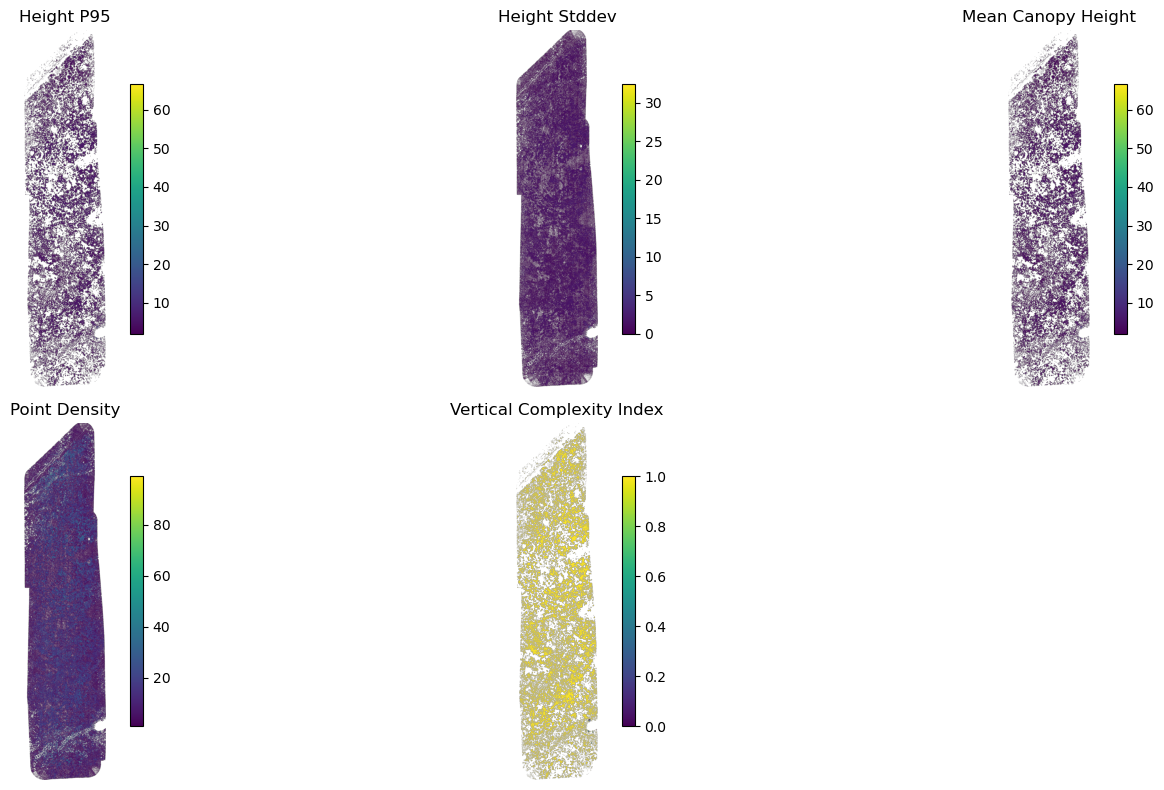

In [ ]:
tif_files = sorted(glob.glob(os.path.join(output_dir, "*.tif")))

selected_files = tif_files[:6]

n_cols = 3
n_rows = (len(selected_files) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4 * n_rows))

for i, tif_path in enumerate(selected_files):
    with rasterio.open(tif_path) as src:
        data = src.read(1, masked=True)
        name = os.path.basename(tif_path).replace(".tif", "")

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(data, cmap="viridis")
    plt.title(name.replace("_", " ").title())
    plt.colorbar(shrink=0.7)
    plt.axis("off")

plt.tight_layout()
plt.show()